In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
from tqdm import tqdm
import gridstatus

In [2]:
api_key_fpath = Path("eia-api-key.txt")
with open(api_key_fpath, "r") as file:
    api_key = file.readlines()[0].strip('/n')

In [3]:
from gridstatus import EIA

# EIA - MISO Data

Get demand data for MISO from 2023

In [4]:
eia = EIA(api_key)

In [5]:
data_route = 'electricity/rto/region-data'
demand_dataset = eia.get_dataset(data_route,
                          start="2023-01-01",
                          end="2024-01-01",
                          facets={'respondent':'MISO',
                                  'type':['D']},
                          n_workers=4,
                          verbose=True).reset_index(drop=True)

Fetching data from https://api.eia.gov/v2/electricity/rto/region-data/data/
Params: {'start': '2023-01-01T00', 'end': '2024-01-01T00', 'frequency': 'hourly', 'data': ['value'], 'facets': {'respondent': ['MISO'], 'type': ['D']}, 'offset': 0, 'length': 5000, 'sort': [{'column': 'period', 'direction': 'asc'}, {'column': 'respondent', 'direction': 'asc'}, {'column': 'type', 'direction': 'asc'}]}
Concurrent workers: 4
Total records: 8761
Total pages: 2
Fetching data:


100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.05it/s]


In [6]:
demand_dataset.set_index("Interval End", drop=True, inplace=True)
demand_dataset.drop(columns=['Interval Start','Respondent Name', 'Respondent'], inplace=True)
demand_dataset.head()

,Load
Interval End,
2023-01-01 00:00:00+00:00,70159.0
2023-01-01 01:00:00+00:00,69592.0
2023-01-01 02:00:00+00:00,68133.0
2023-01-01 03:00:00+00:00,66497.0
2023-01-01 04:00:00+00:00,64874.0


In [7]:
demand_dataset=demand_dataset.iloc[:8760, :]

Text(0.5, 1.0, '2023 MISO Hourly Electricity Demand')

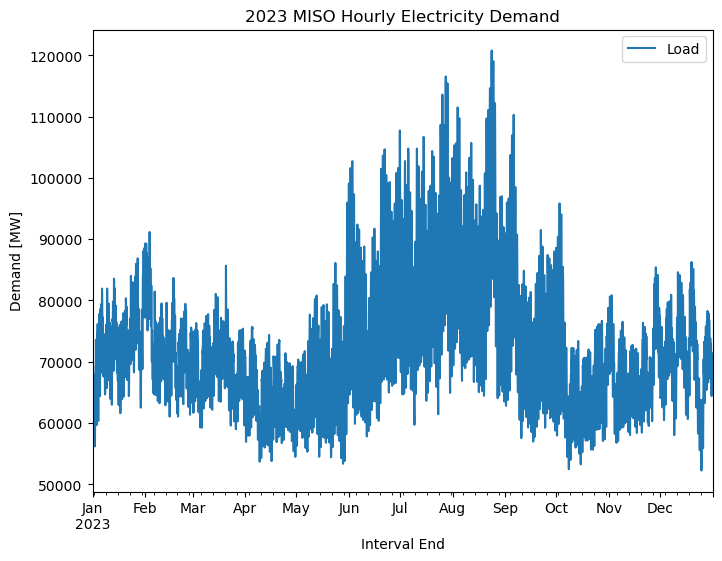

In [8]:
fig, ax = plt.subplots(figsize=(8,6), facecolor='w')
demand_dataset.plot(ax=ax)
ax.set_ylabel("Demand [MW]")
ax.set_title("2023 MISO Hourly Electricity Demand")
# uncomment to save figure
# plt.savefig("2023-miso-demand.png", dpi=400)

In [9]:
# uncomment to save data
# demand_dataset.to_csv(".\\2023-miso-demand.csv")

In [10]:
facets = eia.list_facets("electricity/rto/fuel-type-data")

In [11]:
facets.keys()

dict_keys(['respondent', 'fueltype'])

In [12]:
pd.DataFrame(facets['fueltype'])

,totalFacets,facets
0,9,"{'id': 'SUN', 'name': 'Solar'}"
1,9,"{'id': 'WAT', 'name': 'Hydro'}"
2,9,"{'id': 'NUC', 'name': 'Nuclear'}"
3,9,"{'id': 'WND', 'name': 'Wind'}"
4,9,"{'id': 'NG', 'name': 'Natural gas'}"
5,9,"{'id': 'OIL', 'name': 'Petroleum'}"
6,9,"{'id': 'COL', 'name': 'Coal'}"
7,9,"{'id': 'OTH', 'name': 'Other'}"
8,9,"{'id': 'UNK', 'name': 'Unknown'}"


In [13]:
data_route = 'electricity/rto/fuel-type-data'
dataset = eia.get_dataset(data_route,
                          start="2023-01-01",
                          end="2024-01-01",
                          facets={'respondent':'MISO',},
                          n_workers=4,
                          verbose=True).reset_index(drop=True)

Fetching data from https://api.eia.gov/v2/electricity/rto/fuel-type-data/data/
Params: {'start': '2023-01-01T00', 'end': '2024-01-01T00', 'frequency': 'hourly', 'data': ['value'], 'facets': {'respondent': ['MISO']}, 'offset': 0, 'length': 5000, 'sort': [{'column': 'period', 'direction': 'asc'}, {'column': 'respondent', 'direction': 'asc'}, {'column': 'fueltype', 'direction': 'asc'}]}
Concurrent workers: 4
Total records: 61159
Total pages: 13
Fetching data:


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  3.55it/s]


In [14]:
dataset.set_index("Interval End", drop=True, inplace=True)
dataset.drop(columns=['Interval Start','Respondent Name', 'Respondent'], inplace=True)
dataset.head()

,Coal,Hydro,Natural gas,Nuclear,Other,Solar,Wind
Interval End,,,,,,,
2023-01-01 00:00:00+00:00,26715.0,1106.0,21693.0,11167.0,1136.0,1.0,7638.0
2023-01-01 01:00:00+00:00,25653.0,1144.0,21038.0,11172.0,1145.0,0.0,8103.0
2023-01-01 02:00:00+00:00,23788.0,1158.0,19755.0,11175.0,1164.0,1.0,9075.0
2023-01-01 03:00:00+00:00,23277.0,1154.0,19129.0,11174.0,1138.0,1.0,8718.0
2023-01-01 04:00:00+00:00,22616.0,1138.0,18156.0,11187.0,1119.0,0.0,8823.0


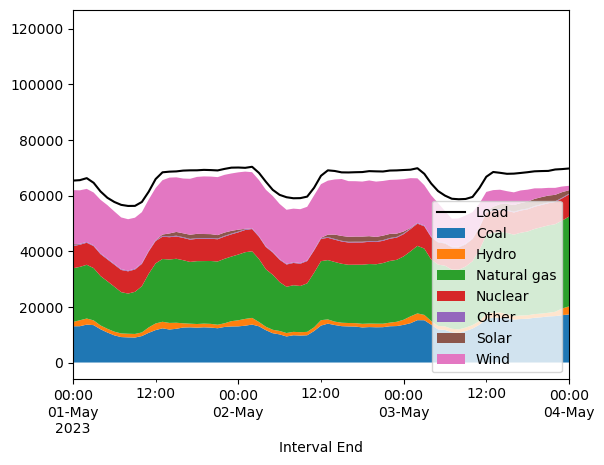

In [15]:
fig, ax = plt.subplots()
demand_dataset.plot(ax=ax, color='k')
total = np.zeros(len(dataset))
for i, col in enumerate(dataset.columns):
    tech_data = dataset[col].values
    ax.fill_between(dataset.index, total, total+tech_data, label=col)
    total+=tech_data
ax.legend()
m = 5
d = 1
d_delta = 4
yr = 2023
ax.set_xlim(pd.Timestamp(day=d, month=m, year=yr), pd.Timestamp(day=d_delta, month=m, year=yr))
plt.show()

<Axes: xlabel='Interval End'>

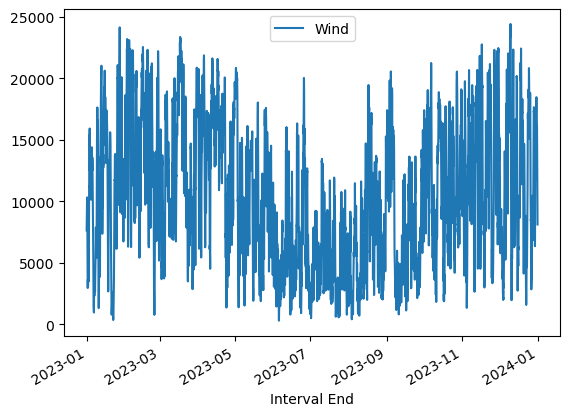

In [16]:
dataset.plot(y='Wind')

In [62]:
solar = dataset[['Solar']]
solar = solar.resample('h').interpolate()[:-1]
solar.columns=['region1']
wind = dataset[['Wind']]
wind = wind.resample('h').interpolate()[:-1]
wind.columns=['region1']

In [64]:
solar.index = solar.index.tz_localize(None)
wind.index = wind.index.tz_localize(None)

In [65]:
wind

,region1
Interval End,
2023-01-01 00:00:00,7638.0
2023-01-01 01:00:00,8103.0
2023-01-01 02:00:00,9075.0
2023-01-01 03:00:00,8718.0
2023-01-01 04:00:00,8823.0
...,...
2023-12-31 19:00:00,11799.0
2023-12-31 20:00:00,11074.0
2023-12-31 21:00:00,10717.0


In [41]:
demand_dataset.index = demand_dataset.index.tz_localize(None)

In [67]:
solar.to_csv("../calliope_model/timeseries_data/2023-miso-solar.csv")
wind.to_csv("../calliope_model/timeseries_data/2023-miso-wind.csv")

In [19]:
dataset.max(axis=0)

Coal           37447.0
Hydro           3535.0
Natural gas    56235.0
Nuclear        11791.0
Other           1230.0
Solar           3253.0
Wind           24408.0
dtype: float64

In [24]:
spots = eia.get_daily_spots_and_futures()

In [27]:
spots['natural_gas']

,date,region,natural_gas_price,natural_gas_percent_change,electricity_price,electricity_percent_change,spark_spread
0,2024-03-22,New England,1.64,-8.9,28.73,8.4,17.26
1,2024-03-22,New York City,1.48,1.1,30.21,-6.5,19.88
2,2024-03-22,Mid-Atlantic,1.47,0.7,29.41,-7.8,19.14
3,2024-03-22,Midwest,-0.07,-104.7,17.53,-16.0,18.01
4,2024-03-22,Louisiana,1.50,-3.2,17.50,-10.3,7.00
5,2024-03-22,Houston,1.10,-18.8,17.50,-28.6,9.80
6,2024-03-22,Southwest,1.17,5.6,11.75,-19.0,3.57
7,2024-03-22,Southern CA,1.23,-0.1,-4.85,-137.3,0.00
8,2024-03-22,Northern CA,2.13,-6.2,21.37,-14.9,6.48
9,2024-03-22,Northwest,1.25,-3.8,24.67,7.3,15.92


In [32]:
from unyt import mmbtu, kWh, MWh

In [36]:
a = 2.74/mmbtu

a.to(1/MWh)

unyt_quantity(9.34926765, '1/MWh')